## [Training a causal language model from scratch](https://huggingface.co/course/chapter7/6?fw=pt)
Up until now, we've mostly been using pretrained models and fine-tuning them for new use cases by reusing the weights from pretraining. As we saw in [Chapter 1](https://huggingface.co/course/chapter1), this is commonly referred to as *transfer learning*, and it's a very successful strategy for applying Transformer models to most real-world use cases where labeled data is sparse. In this chapter, we'll take a different approach and train a completely new model from scratch. This is a good approach to take if you have a lot of data and it is very different from the pretraining data used for the available models. However, it also requires considerably more compute resources to pretrain a language model than just to fine-tune an existing one. Examples where it can make sense to train a new model include for datasets consisting of musical notes, molecular sequences such as DNA, or programming languages. The latter have recently gained traction thanks to tools such as TabNine and GitHub's Copilot, powered by OpenAI's Codex model, that can generate long sequences of code. This task of text generation is best addressed with auto-regressive or causal language models such as GPT-2.

In this section we will build a scaled-down version of a code generation model: we'll focus on one-line completions instead of full functions or classes, using a subset of Python code. When working with data in Python you are in frequent contact with the Python data science stack, consisting of the `matplotlib`, `seaborn`, `pandas`, and `scikit-learn` libraries. When using those frameworks it's common to need to look up specific commands, so it would be nice if we could use a model to complete these calls for us.

In [1]:
from IPython.display import HTML
HTML('<iframe width="640" height="360" src="https://www.youtube.com/embed/Vpjb1lu0MDk" allowfullscreen></iframe>')

/home/matthias/.local/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [Chapter 6](https://huggingface.co/course/chapter6) we created an efficient tokenizer to process Python source code, but what we still need is a large-scale dataset to pretrain a model on. Here, we'll apply our tokenizer to a corpus of Python code derived from GitHub repositories. We will then use the `Trainer` API and 🤗 Accelerate to train the model. Let's get to it!

<img style="float=center;" src="sections/section_7/images/gradio_clear_submit.png" width="80%">

This is actually showcasing the model that was trained and uploaded to the Hub using the code shown in this section. You can find it [here](https://huggingface.co/huggingface-course/codeparrot-ds?text=plt.imshow%28). Note that since there is some randomization happening in the text generation, you will probably get a slightly different result.

### Gathering the data
Python code is abundantly available from code repositories such as GitHub, which we can use to create a dataset by scraping for every Python repository. This was the approach taken in the [Transformers textbook](https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/) to pretrain a large GPT-2 model. Using a GitHub dump of about 180 GB containing roughly 20 million Python files called `codeparrot`, the authors built a dataset that they then shared on the [Hugging Face Hub](https://huggingface.co/datasets/transformersbook/codeparrot).

However, training on the full corpus is time- and compute-consuming, and we only need the subset of the dataset concerned with the Python data science stack. So, let's start by filtering the `codeparrot` dataset for all files that include any of the libraries in this stack. Because of the dataset's size, we want to avoid downloading it; instead, we'll use the streaming feature to filter it on the fly. To help us filter the code samples using the libraries we mentioned earlier, we'll use the following function:

In [2]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True 
    return False

Let's test it on two examples:

In [3]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"
any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)

(False, True)

We can use this to create a function that will stream the dataset and filter the elements we want:

In [4]:
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    print(filtered_dict)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

Then we can simply apply this function to the streaming dataset:

```python
%%time
# This cell will take a very long time to execute, so you should skip it and go to the next one!
split = "train" # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)
# 3.26% of data after filtering.
# CPU times: user 34min 49s, sys: 2min 54s, total: 37min 43s
# Wall time: 3h 58min 3s
```

As of July 2024, this leaves us with 3.26% (606720/18593791) of the original dataset, which is still quite sizable — the resulting dataset is 6 GB and consists of 18.6 million Python scripts!

Filtering the full dataset can take 2-4h depending on your machine and bandwidth. If you don't want to go through this lengthy process yourself, we provide the filtered dataset on the Hub for you to download:

In [5]:
ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")
raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(80000)), # originally .select(range(50000))
        "valid": ds_valid.shuffle().select(range(1000))   # originally .select(range(500))
    }
)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 80000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 1000
    })
})

> <font color="darkgreen">Pretraining the language model will take a while. We suggest that you first run the training loop on a sample of the data by uncommenting the two partial lines above, and make sure that the training successfully completes and the models are stored. Nothing is more frustrating than a training run failing at the last step because you forgot to create a folder or because there’s a typo at the end of the training loop!</font>

Let's look at an example from the dataset. We'll just show the first 200 characters of each field:

In [6]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: meppe/ros-ort
PATH: src/frcnn/src/frcnn/kalman_tracker.py
COPIES: 1
SIZE: 16068
CONTENT: import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import rospy
from ort_msgs.msg import Object_bb_list
from sensor_msgs.msg import Image
from cv_bridge import 
LICENSE: gpl-3.0


We can see that the content field contains the code that we want our model to train on. Now that we have a dataset, we need to prepare the texts so they're in a format suitable for pretraining.

### Preparing the dataset

In [7]:
HTML('<iframe width="640" height="360" src="https://www.youtube.com/embed/ma1TrR7gE7I" allowfullscreen></iframe>')

/home/matthias/.local/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The first step will be to tokenize the data, so we can use it for training. Since our goal is to mainly autocomplete short function calls, we can keep the context size relatively small. This has the benefit that we can train the model much faster and it requires significantly less memory. If it is important for your application to have more context (for example, if you want the model to write unit tests based on a file with the function definition), make sure you increase that number, but also keep in mind that this comes with a greater GPU memory footprint. For now, let's fix the context size at 128 tokens, as opposed to the 1024 or 2048 used in GPT-2 or GPT-3, respectively.

Most documents contain many more than 128 tokens, so simply truncating the inputs to the maximum length would eliminate a large fraction of our dataset. Instead, we'll use the `return_overflowing_tokens` option to tokenize the whole input and split it into several chunks, as we did in [Chapter 6](https://huggingface.co/course/chapter6/4). We'll also use the `return_length` option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we'll get rid of these pieces to avoid padding issues; we don't really need them as we have plenty of data anyway.

<img style="float=center;" src="sections/section_7/images/tokenized_text.svg" width="90%">

Let's see exactly how this works by looking at the first two examples:

In [8]:
from transformers import AutoTokenizer
context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")
outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)
print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

/home/matthias/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Input IDs length: 53
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 8, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 81]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We can see that we get 34 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 128 tokens (117 and 41, respectively). These represent just a small fraction of the total chunks that we have, so we can safely throw them away. With the `overflow_to_sample_mapping` field, we can also reconstruct which chunks belonged to which input samples.

With this operation we're using a handy feature of the `Dataset.map()` function in 🤗 Datasets, which is that it does not require one-to-one maps; as we saw in [section 3](https://huggingface.co/course/chapter7/3), we can create batches with more or fewer elements than the input batch. This is useful when doing operations like data augmentation or data filtering that change the number of elements. In our case, when tokenizing each element into chunks of the specified context size, we create many samples from each document. We just need to make sure to delete the existing columns, since they have a conflicting size. If we wanted to keep them, we could repeat them appropriately and return them within the `Dataset.map()` call:

In [9]:
%%time
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

CPU times: user 11min 11s, sys: 7.1 s, total: 11min 18s
Wall time: 4min 39s


DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 2205145
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 29452
    })
})

We now have 16.7 million examples with 128 tokens each, which corresponds to about 2.1 billion tokens in total. For reference, OpenAI's GPT-3 and Codex models are trained on 300 and 100 billion tokens, respectively, where the Codex models are initialized from the GPT-3 checkpoints. Our goal in this section is not to compete with these models, which can generate long, coherent texts, but to create a scaled-down version providing a quick autocomplete function for data scientists.

Now that we have the dataset ready, let's set up the model!

> ✏️ Try it out! <font color="darkgreen">Getting rid of all the chunks that are smaller than the context size wasn't a big issue here because we're using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow. A more efficient way to prepare the data is to join all the tokenized samples in a batch with an `eos_token_id` token in between, and then perform the chunking on the concatenated sequences. As an exercise, modify the `tokenize()` function to make use of that approach. Note that you'll want to set `truncation=False` and remove the other arguments from the tokenizer to get the full sequence of token IDs.
</font>

In [10]:
%%time
# trying it out 1
from more_itertools import chunked

def try_it_tokenize(element):
    # 1. get batch
    outputs = tokenizer(
        element["content"],
        truncation=False
    )
    eos_token_id = tokenizer.eos_token_id
    input_ids_batch = outputs["input_ids"]
    batch_length = len(input_ids_batch) # get length of batch (required for return value)
    input_ids_batch_flat = []
    # 2. for each item_i in batch, get input_ids_i
    for input_ids_i in input_ids_batch:
        # 3. make sure each input_ids_i ends with eos_token_id (use a loop and assert)
        if input_ids_i[-1]!=eos_token_id:
            input_ids_i += [eos_token_id]
        # 4. concatenate all input_ids_i into non-nested list variable input_ids_batch_flat
        input_ids_batch_flat += input_ids_i
    # 5. use "chunked" to turn input_ids_batch_flat into a list of chunks ...
    # ... where each chunk (but maybe the last one) has length=context_length-1
    input_ids_chunks = []
    for input_ids_chunk in list(chunked(input_ids_batch_flat, context_length-1)):
        input_ids_chunk = list(input_ids_chunk)
        # 6. add eos_token to the end of each chunk
        input_ids_chunk.append(eos_token_id)
        input_ids_chunks.append(input_ids_chunk)
    # 7. return the list of chunks (=batch) with the correct length (=batch_length)
    return {"input_ids": input_ids_chunks[:batch_length]}
    
tokenized_datasets_try = (
    raw_datasets
    .map(try_it_tokenize, batched=True)
    .remove_columns(["repo_name", "path", "copies", "size", "content", "license"])
)
tokenized_datasets_try

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4744 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

CPU times: user 11min 40s, sys: 5.14 s, total: 11min 46s
Wall time: 4min 15s


DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 80000
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 1000
    })
})

Now, let's demonstrate that the `try_it_tokenize` function does indeed *concatenate sequences* to make better use of the model's context length!

In [11]:
%%time
# still trying it out (confirm success)
for split in ["train", "valid"]:
    for j in range(len(tokenized_datasets_try[split])):
        input_ids_j = tokenized_datasets_try[split]["input_ids"][j]
        eos_token_positions = [i for i, input_id in enumerate(input_ids_j) if input_id==tokenizer.eos_token_id]
        if len(eos_token_positions)>1:
            print(f"split {split}, instance {j}, positions {eos_token_positions}")
            break

split train, instance 37, positions [45, 127]
split valid, instance 7, positions [20, 127]
CPU times: user 2min 8s, sys: 2.02 s, total: 2min 10s
Wall time: 2min 10s


### Initializing a new model
Our first step is to freshly initialize a GPT-2 model. We'll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the bos and eos (beginning and end of sequence) token IDs:

In [12]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

/home/matthias/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


With that configuration, we can load a new model. Note that this is the first time we don't use the `from_pretrained()` function, since we're actually initializing a model ourself:

In [13]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


Our model has 124M parameters that we'll have to tune. Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the `DataCollatorForLanguageModeling` collator, which is designed specifically for language modeling (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don't need to duplicate the `input_ids`.

Note that `DataCollatorForLanguageModeling` supports both masked language modeling (MLM) and causal language modeling (CLM). By default it prepares data for MLM, but we can switch to CLM by setting the argument `mlm=False`:

In [14]:
from transformers import DataCollatorForLanguageModeling
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Let's have a look at an example:

In [15]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


We can see that the examples have been stacked and all the tensors have the same shape.

> <font color="darkred">⚠️ Shifting the inputs and labels to align them happens inside the model, so the data collator just copies the inputs to create the labels.</font>

Now we have everything in place to actually train our model — that wasn't so much work after all! Before we start training we should log in to Hugging Face. If you're working in a notebook, you can do so with the following utility function:

In [16]:
from huggingface_hub import notebook_login
notebook_login()

This will display a widget where you can enter your Hugging Face login credentials.

If you aren't working in a notebook, just type the following line in your terminal:

```zsh
huggingface-cli login
```

All that's left to do is configure the training arguments and fire up the `Trainer`. We'll use a cosine learning rate schedule with some warmup and an effective batch size of 256 (`per_device_train_batch_size * gradient_accumulation_steps`). Gradient accumulation is used when a single batch does not fit into memory, and incrementally builds up the gradient through several forward/backward passes. We'll see this in action when we create the training loop with 🤗 Accelerate.

In [17]:
from transformers import Trainer, TrainingArguments
from huggingface_hub import create_repo
username = "mdroth"
reponame = "codeparrot-model"
try:
    create_repo(repo_name)
except:
    print(f"Repository exists already:\n{username}/{reponame}")
args = TrainingArguments(
    output_dir="sections/section_7/logs/codeparrot-model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    eval_steps=4000,
    logging_steps=4000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=4000,
    fp16=True,
    # push_to_hub=True, # not required since we will run trainer.push_to_hub(), anyway
    hub_model_id=f"{username}/{reponame}"
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    #train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"]
)

Repository exists already:
mdroth/codeparrot-model


/home/matthias/.local/lib/python3.10/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Now we can just start the `Trainer` and wait for training to finish. Depending on whether you run it on the full or a subset of the training set this will take 20 or 2 hours, respectively, so grab a few coffees and a good book to read!

In [18]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=39, training_loss=9.808173546424278, metrics={'train_runtime': 57.4419, 'train_samples_per_second': 87.044, 'train_steps_per_second': 0.679, 'total_flos': 326092455936000.0, 'train_loss': 9.808173546424278, 'epoch': 1.0})

After training completes, we can push the model and tokenizer to the Hub:

In [19]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/497M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

> ✏️ Try it out! <font color="darkgreen">It only took us about 30 lines of code in addition to the `TrainingArguments` to get from raw texts to training GPT-2. Try it out with your own dataset and see if you can get good results!</font>

In [20]:
# trying it out 2
def tokenize2(element):
    outputs = tokenizer(
        element["question"],
        padding=True,
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
        return_length=True,
    )
    return outputs
try2_dataset = (
    load_dataset("Open-Orca/OpenOrca")["train"]
    .select(range(100000)) # use subset of data
    .filter(lambda item: isinstance(item["response"], str)) # ensure the response is a string
    .filter(lambda item: item["response"][0].isdigit() or item["response"][0].isalpha()) # .isdigit => digit, .isalpha => letter
    .map(tokenize2) # tokenize
    .map(lambda item: {"input_ids": item["input_ids"][0]}) # remove nesting
    .remove_columns(["id", "system_prompt", "length", "overflow_to_sample_mapping", "attention_mask", "question", "response"])
)
print(try2_dataset)
try2_train_valid_split = try2_dataset.train_test_split(test_size=0.25)
try2_train_split = try2_train_valid_split["train"]
try2_valid_split = try2_train_valid_split["test"]
try2_model = GPT2LMHeadModel(config)
try2_datacollator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
#
try2_args = TrainingArguments(
    output_dir="sections/section_7/logs/try2_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    eval_steps=4000,
    logging_steps=4000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=4000,
    fp16=True
)
try2_trainer = Trainer(
    model=try2_model,
    tokenizer=tokenizer,
    args=try2_args,
    data_collator=try2_datacollator,
    train_dataset=try2_train_split,
    eval_dataset=try2_valid_split
)
try2_trainer.train()

Map:   0%|          | 0/93265 [00:00<?, ? examples/s]

Map:   0%|          | 0/93265 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids'],
    num_rows: 93265
})


/home/matthias/.local/lib/python3.10/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=546, training_loss=6.074870685954671, metrics={'train_runtime': 784.5989, 'train_samples_per_second': 89.151, 'train_steps_per_second': 0.696, 'total_flos': 4565294383104000.0, 'train_loss': 6.074870685954671, 'epoch': 1.0})

> 💡 <font color="darkgreen">If you have access to a machine with multiple GPUs, try to run the code there. The `Trainer` automatically manages multiple machines, and this can speed up training tremendously.</font>

## Code generation with a pipeline
Now is the moment of truth: let's see how well the trained model actually works! We can see in the logs that the loss went down steadily, but to put the model to the test let's take a look at how well it works on some prompts. To do that we'll wrap the model in a text generation `pipeline`, and we'll put it on the GPU for fast generations if there is one available:

In [21]:
import torch
from transformers import pipeline
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation",
    model=f"{username}/{reponame}",
    device=device
)
pipe

/home/matthias/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/497M [00:00<?, ?B/s]

Let's start with the simple task of creating a scatter plot:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with (x, y)
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with (x, y)
_,..,,. =_,.


After several tries, the above cell output the following working code:

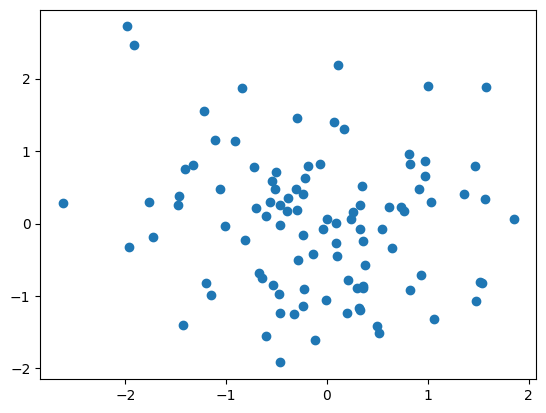

In [23]:
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with (x, y)
p = plt.scatter(x, y)

Does it also work for a `pandas` operation? Let's see if we can create a `DataFrame` from two arrays:

In [24]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
... in.(__._.,(_


xxx Nice, that's the correct answer — although it then inserts the column `x` again. Since the number of generated tokens is limited, the following `for` loop is cut off. Let's see if we can do something a bit more complex and have the model help us use the `groupby` operation: xxx

In [25]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession

. distribution.(


Not bad; that's the right way to do it. Finally, let's see if we can also use it for `scikit-learn` and set up a Random Forest model:

In [26]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:

,_negate.
thead


_(





Looking at these few examples, it seems that the model has learned some of the syntax of the Python data science stack (of course, we would need to evaluate it more thoroughly before deploying the model in the real world). Sometimes it requires more customization of the model training to achieve the necessary performance for a given use case, however. For example, what if we would like to dynamically update the batch size or have a conditional training loop that skips bad examples on the fly? One option would be to subclass the `Trainer` and add the necessary changes, but sometimes it's simpler to write the training loop from scratch. That's where 🤗 Accelerate comes in.

## Training with 🤗 Accelerate
We've seen how to train a model with the `Trainer`, which can allow for some customization. However, sometimes we want full control over the training loop, or we want to make some exotic changes. In this case 🤗 Accelerate is a great choice, and in this section we'll go through the steps to use it to train our model. To make things more interesting, we’ll also add a twist to the training loop.

In [27]:
HTML('<iframe width="640" height="360" src="https://www.youtube.com/embed/Hm8_PgVTFuc" allowfullscreen></iframe>')

/home/matthias/.local/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Since we are mainly interested in sensible autocompletion for the the data science libraries, it makes sense to give more weight to training samples that make more use of these libraries. We can easily identify these examples through the use of keywords such as `plt`, `pd`, `sk`, `fit`, and `predict`, which are the most frequent import names for `matplotlib.pyplot`, `pandas`, and `sklearn` as well as the fit/predict pattern of the latter. If these are each represented as a single token, we can easily check if they occur in the input sequence. Tokens can have a whitespace prefix, so we’ll also check for those versions in the tokenizer vocabulary. To verify that it works, we’ll add one test token which should be split into multiple tokens:

In [28]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

Keyword has not single token: testtest


Great, that seems to work nicely! We can now write a custom loss function that takes the input sequence, the logits, and the key tokens we just selected as inputs. First, we need to align the logits and inputs: the input sequence shifted by one to the right forms the labels, since the next token is the label for the current token. We can achieve this by starting the labels from the second token of the input sequence, since the model does not make a prediction for the first token anyway. Then we cut off the last logit, as we don't have a label for the token that follows the full input sequence. With that we can compute the loss per sample and count the occurrences of all keywords in each sample. Finally, we calculate the weighted average over all samples using the occurrences as weights. Since we don't want to throw away all the samples that have no keywords, we add `1` to the weights:

In [29]:
from torch.nn import CrossEntropyLoss
import torch
#
def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

keytoken_weighted_loss

<function __main__.keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0)>

Before we can start training with this awesome new loss function, we need to prepare a few things:
- We need dataloaders to load the data in batches.
- We need to set up weight decay parameters.
- From time to time we want to evaluate, so it makes sense to wrap the evaluation code in a function.

Let's start with the dataloaders. We only need to set the dataset's format to `"torch"`, and then we can pass it to a PyTorch `DataLoader` with the appropriate batch size:

In [32]:
from torch.utils.data.dataloader import DataLoader
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=32)

Next, we group the parameters so that the `optimizer` knows which ones will get an additional weight decay. Usually, all `bias` and `LayerNorm` weights terms are exempt from this; here's how we can do this:

In [33]:
weight_decay = 0.1
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]
#
get_grouped_params

<function __main__.get_grouped_params(model, no_decay=['bias', 'LayerNorm.weight'])>

Since we want to evaluate the model regularly on the validation set during training, let's write a function for that as well. It just runs through the evaluation dataloader and gathers all the losses across processes:

In [34]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()
#
evaluate

<function __main__.evaluate()>

With the `evaluate()` function we can report loss and [perplexity](https://huggingface.co/course/chapter7/3) at regular intervals. Next, we redefine our model to make sure we train from scratch again:

In [35]:
model = GPT2LMHeadModel(config)
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

We can then define our optimizer, using the function from before to split the parameters for weight decay:

In [36]:
from torch.optim import AdamW
optimizer = AdamW(get_grouped_params(model), lr=5e-4)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.0
)

$\checkmark$